In [1]:
# 导入库
import pandas as pd
import matplotlib.pyplot as plt
import portfolio_construction_functions as pc

In [2]:
# 导入情感数据
path_Reuters = '../Data/Sentiment_Scores/Merged Sentiment Reuters.csv'
path_MW = '../Data/Sentiment_Scores/Merged Sentiment MW.csv'
path_CNN = '../Data/Sentiment_Scores/Merged Sentiment CNN.csv'
path_TG = '../Data/Sentiment_Scores/Merged Sentiment TG.csv'

df_Reuters_sentiment = pd.read_csv(path_Reuters)
df_MW_sentiment = pd.read_csv(path_MW)
df_CNN_sentiment = pd.read_csv(path_CNN)
df_TG_sentiment = pd.read_csv(path_TG)

# 拼接两个网站的情感分数
df_sentiment = [df_MW_sentiment, df_Reuters_sentiment, df_CNN_sentiment, df_TG_sentiment]
# df_sentiment = [df_MW_sentiment]
# df_sentiment = [df_Reuters_sentiment]
df_sentiment = pd.concat(df_sentiment)
df_sentiment = df_sentiment.groupby(['Date', 'Country']).mean(numeric_only=True).reset_index()

# 修改列名
df_sentiment = df_sentiment.rename(columns={
    'LMD_Polarity': 'LMD',
    'HIV4_Polarity': 'HIV4',
    'Vader_Polarity': 'Vader',
    'FinBert_Polarity': 'FinBert'
})

# 展示数据
df_sentiment.head()

,Date,Country,Unnamed: 0,LMD,HIV4,Vader,FinBert,Unnamed: 0.1
0,2012-01-01,Australia,0.00,NaN,NaN,NaN,NaN,0.0
1,2012-01-01,Canada,4153.75,NaN,NaN,NaN,NaN,1.0
2,2012-01-01,China,8307.50,-0.619565,0.382353,-0.10765,0.0,2.0
3,2012-01-01,Denmark,12461.25,NaN,NaN,NaN,NaN,3.0
4,2012-01-01,Finland,16615.00,NaN,NaN,NaN,NaN,4.0


In [3]:
# 导入收益率数据
df_return = pd.read_csv('../Data/daily_return_modified.csv')

# 展示数据
df_return.head()

# # 展示为0或者NA的数据的数量
# print('Number of 0 or NA in each column:')
# print(df_return.isin([0, np.nan]).sum())


,Date,New Zealand,United Kingdom,Finland,Norway,United States,Sweden,South Korea,Japan,Canada,...,Australia,Germany,France,China,Switzerland,Spain,Denmark,Italy,Singapore,Portugal
0,2011-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-02,-0.010866,-0.207038,0.302897,0.235483,0.489692,0.154354,0.094609,-0.042270,0.178307,...,0.053087,0.393824,-1.345329,0.328191,0.241278,0.536400,0.065521,-0.189497,-0.251753,0.148492
2,2011-12-05,0.077141,-0.460678,-0.474224,-0.158909,-0.084015,-0.179613,0.056292,0.165816,0.227525,...,0.302855,-0.615728,1.099039,0.264403,-0.125720,3.778843,-1.723893,5.259712,-0.012405,3.308727
3,2011-12-06,0.201784,0.810078,0.100602,-0.190226,-0.406179,0.198203,-0.004941,0.066255,-0.330724,...,0.354603,0.150150,-0.863361,-0.157734,0.335027,-0.630513,0.272330,0.715348,0.047384,1.062182
4,2011-12-07,0.187048,0.129148,0.496636,0.290407,0.543003,0.567308,-0.043160,0.002849,0.596567,...,-0.273399,0.762903,0.199724,0.001528,0.198283,-1.476326,-0.028845,-0.948723,-0.251362,1.737582


In [4]:
# 转换日期格式
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date'], format='%Y-%m-%d')
df_return['Date'] = pd.to_datetime(df_return['Date'], format='%Y-%m-%d')

# 生成日期范围
all_dates = pd.date_range(start='2012-01-01', end='2023-06-30').tolist()
df_return = df_return[df_return['Date'].isin(all_dates)]
df_sentiment = df_sentiment[df_sentiment['Date'].isin(all_dates)]

# 去掉无用的列
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0'])
df_sentiment = df_sentiment.drop(columns=['Unnamed: 0.1'])


# 过滤掉周末的情感数据
df_sentiment = df_sentiment[df_sentiment['Date'].dt.dayofweek < 5]


# 填充NA为0
df_sentiment = df_sentiment.fillna(0)

# Calculate the average sentiment for each country
average_polarity = df_sentiment[['LMD', 'HIV4', 'Vader', 'FinBert']].mean(axis=1)

# Create a new DataFrame to store the results
df_sentiment_aver = pd.DataFrame({
    'Date': df_sentiment['Date'],
    'Country': df_sentiment['Country'],
    'Average': average_polarity
})

# Rank the average sentiment for each day
df_sentiment_aver['Average_Rank'] = df_sentiment_aver.groupby('Date')['Average'].rank(ascending=False, method='first')


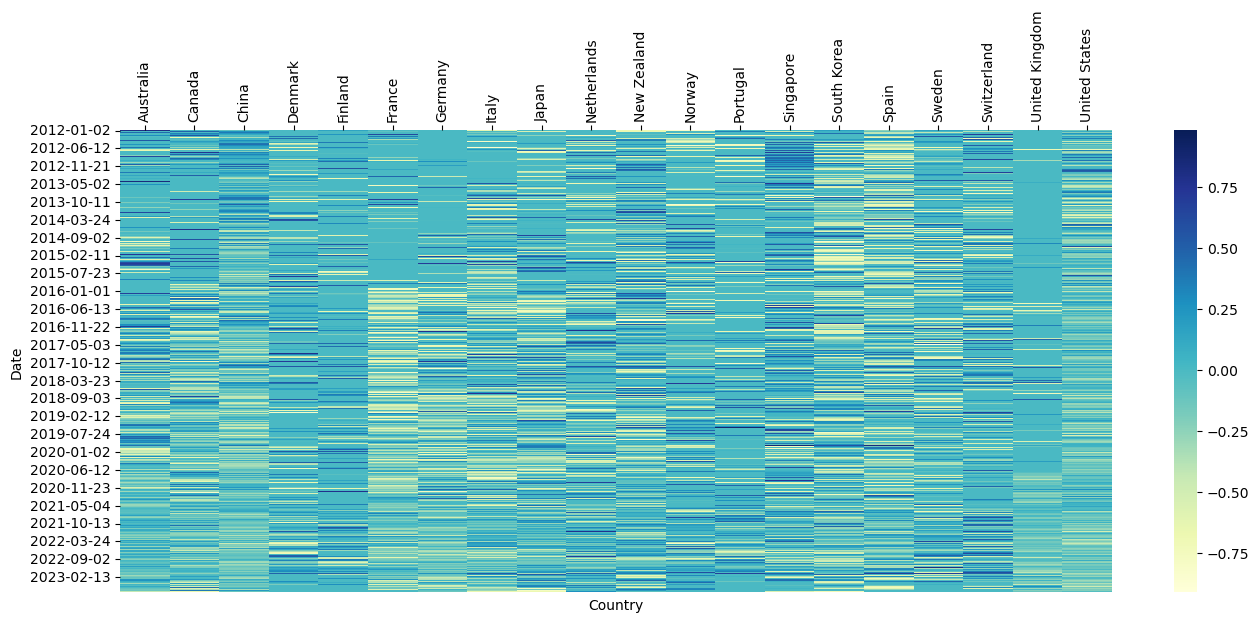

In [5]:
# 展示数据的Heatmap图, 颜色越深代表情感分数越高, 也就是越值得投资
pc.plot_sentiment_heatmap(df_sentiment_aver, '../Data/Images/Heatmap.png')
plt.show()

In [6]:
# 将Average_Polarity和Return赋给merged_data
merged_data = pd.merge(df_sentiment_aver, df_sentiment, on=['Date', 'Country'], how='outer')
df_return_melted = df_return.melt(id_vars='Date', var_name='Country', value_name='Return')
merged_data = pd.merge(merged_data, df_return_melted, on=['Date', 'Country'], how='outer')
column_order = ['Date', 'Country', 'LMD', 'HIV4', 'Vader', 'FinBert', 'Average', 'Return']
merged_data = merged_data[column_order]

merged_data

,Date,Country,LMD,HIV4,Vader,FinBert,Average,Return
0,2012-01-02,Australia,0.999999,0.500000,0.778300,0.940127,0.804607,0.006376
1,2012-01-02,Canada,0.000000,0.000000,0.000000,0.000000,0.000000,0.005310
2,2012-01-02,China,-0.240476,0.046087,0.298500,-0.462352,-0.089560,0.009373
3,2012-01-02,Denmark,0.000000,0.000000,0.000000,0.000000,0.000000,-0.338765
4,2012-01-02,Finland,-0.052632,0.282051,0.957200,-0.591151,0.148867,-0.558697
...,...,...,...,...,...,...,...,...
59995,2023-06-30,Spain,-0.288889,0.333333,0.999400,0.000000,0.260961,0.199337
59996,2023-06-30,Sweden,0.000000,0.000000,0.000000,0.000000,0.000000,0.025266
59997,2023-06-30,Switzerland,0.000000,0.000000,0.000000,0.000000,0.000000,0.154802
59998,2023-06-30,United Kingdom,0.200000,0.500000,0.975300,-0.931831,0.185867,-0.051370


In [7]:
merged_data = merged_data.dropna(subset=['Return'])

## Correlation And Accuracy

In [8]:
correlations_result = pc.check_correlation(merged_data, 'Return')
print(correlations_result)

     Method  Correlation with Return
27      LMD                 0.001311
29  FinBert                -0.001572
31  Average                -0.008062
33    Vader                -0.010821
35     HIV4                -0.012579


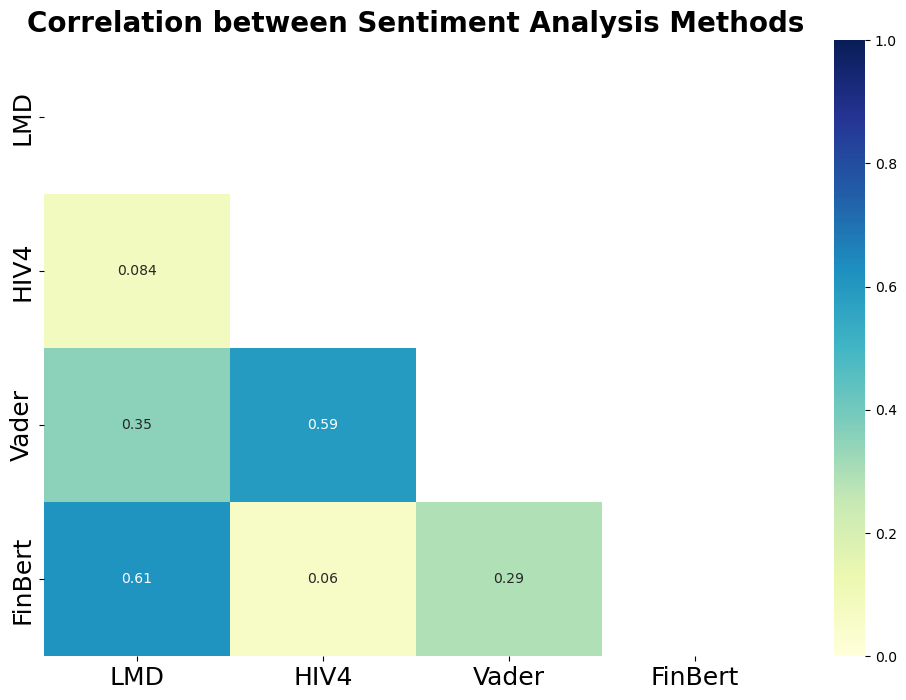

In [9]:
pc.plot_correlation_heatmap(merged_data, columns=['LMD','HIV4','Vader', 'FinBert'], title="Correlation between Sentiment Analysis Methods")
plt.show()

In [10]:
# 使用不同的策略计算收益率
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
dict_ret = pc.compute_strategy_performance(merged_data, strategies, all_dates)

new_portfolio_25 = pd.DataFrame(dict_ret).transpose()
new_portfolio_25 = new_portfolio_25.rename(columns={0: 'LMD', 1: 'HIV4', 2: 'Vader', 3: 'FinBert', 4: 'Average'})
new_portfolio_25.reset_index(inplace=True)
new_portfolio_25.rename(columns={'index': 'Date'}, inplace=True)

# new_portfolio_25.to_csv('../Data/25_percent_portfolio.csv')

In [11]:
new_portfolio_25

,Date,LMD,HIV4,Vader,FinBert,Average
0,2012-01-01,0.000000,0.000000,0.000000,0.000000,0.000000
1,2012-01-02,-0.577807,0.173798,-0.436909,-0.320771,-0.474831
2,2012-01-03,-0.038098,0.042591,0.177495,-0.060627,0.095058
3,2012-01-04,0.067477,-0.120260,-0.331618,-0.103956,-0.288875
4,2012-01-05,0.923248,-0.528058,-0.171978,0.931785,0.671796
...,...,...,...,...,...,...
4194,2023-06-26,0.015587,-0.091675,-0.101832,0.070634,0.007724
4195,2023-06-27,0.082495,0.195766,0.181202,-0.081656,0.117423
4196,2023-06-28,-0.288231,0.206090,-0.122103,-0.189469,-0.225932
4197,2023-06-29,0.031288,0.434450,-0.099838,0.093078,-0.006581


### IR of Long-Short Portfolio

In [12]:
IR_values = pc.compute_information_ratio(new_portfolio_25, strategies)
print(IR_values)

{'LMD': -0.0026684922760924264, 'HIV4': 0.020961730469795475, 'Vader': -0.005949795801490337, 'FinBert': -0.0032723328229201016, 'Average': 0.010967028273985248}


In [13]:
# 计算年化收益率
annualized_ret = pc.compute_annualized_return(new_portfolio_25, strategies)
print(annualized_ret)

{'LMD': nan, 'HIV4': 0.2742947099928199, 'Vader': nan, 'FinBert': nan, 'Average': 0.21677274181112316}


/Users/wanghs/PycharmProjects/ContextualSentimentInvestmentTool/Part 4 PortfolioConstruction/portfolio_construction_functions.py:206: RuntimeWarning: invalid value encountered in double_scalars
  annualized_ret = (1 + total_return) ** (252 / total_days) - 1


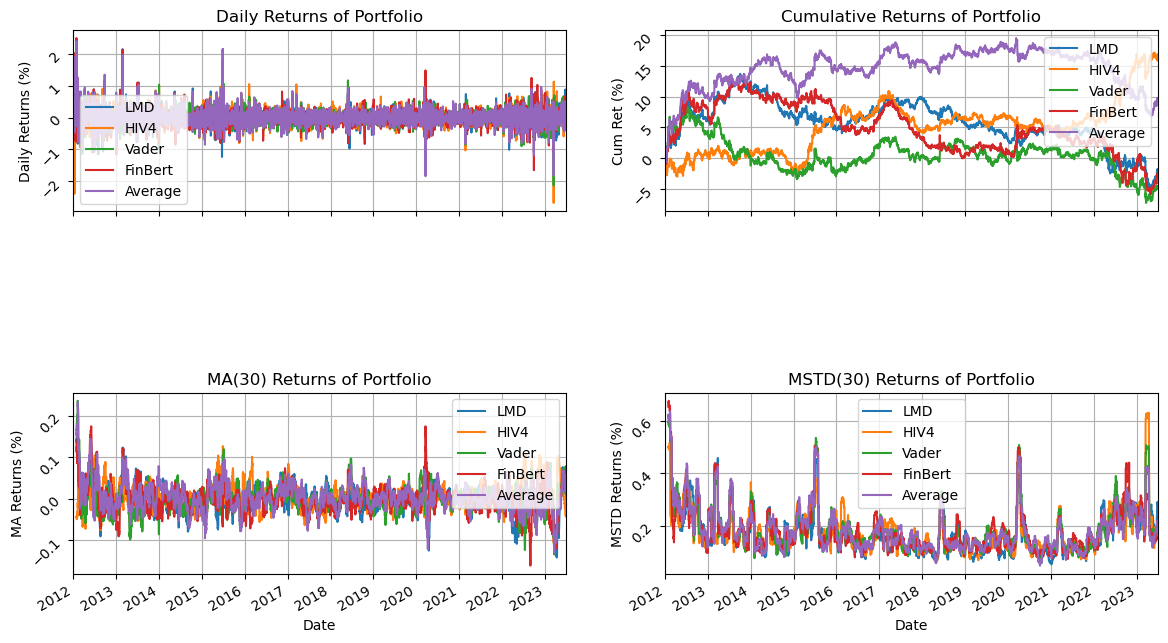

In [14]:
pc.plot_portfolio_summary(new_portfolio_25, start_date='2012-01-01', end_date='2023-06-30')
plt.show()

In [15]:
# 计算累计收益率
df = new_portfolio_25.copy()
# Determine the total number of trading days in the dataset
total_days = 3000

# Dictionary to store the annualized returns and cumulative returns
annualized_returns = {}
cumulative_returns = {}  # Note the naming change to avoid conflict
strategies = ['LMD', 'HIV4', 'Vader', 'FinBert', 'Average']
# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

for strategy in strategies:
    # print(df[strategy].describe())
    # Compute the cumulative return for the strategy
    cumulative_ret = (1 + df[strategy]/100).prod() - 1
    cumulative_returns[strategy] = cumulative_ret  # Store in dictionary
    
    # Calculate the annualized return
    annualized_ret = (1 + cumulative_ret) ** (252 / total_days) - 1
    annualized_returns[strategy] = annualized_ret  # Store in dictionary
    
    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = df[strategy].std() * np.sqrt(252)

    # 计算夏普比率
    sharpe_ratio = (annualized_ret) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

# 输出结果
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"The Sharpe Ratio for {strategy} is {sharpe_ratio:.4f}")

print("Annualized Returns:", annualized_returns)
print("Cumulative Returns:", cumulative_returns)


NameError: name 'np' is not defined

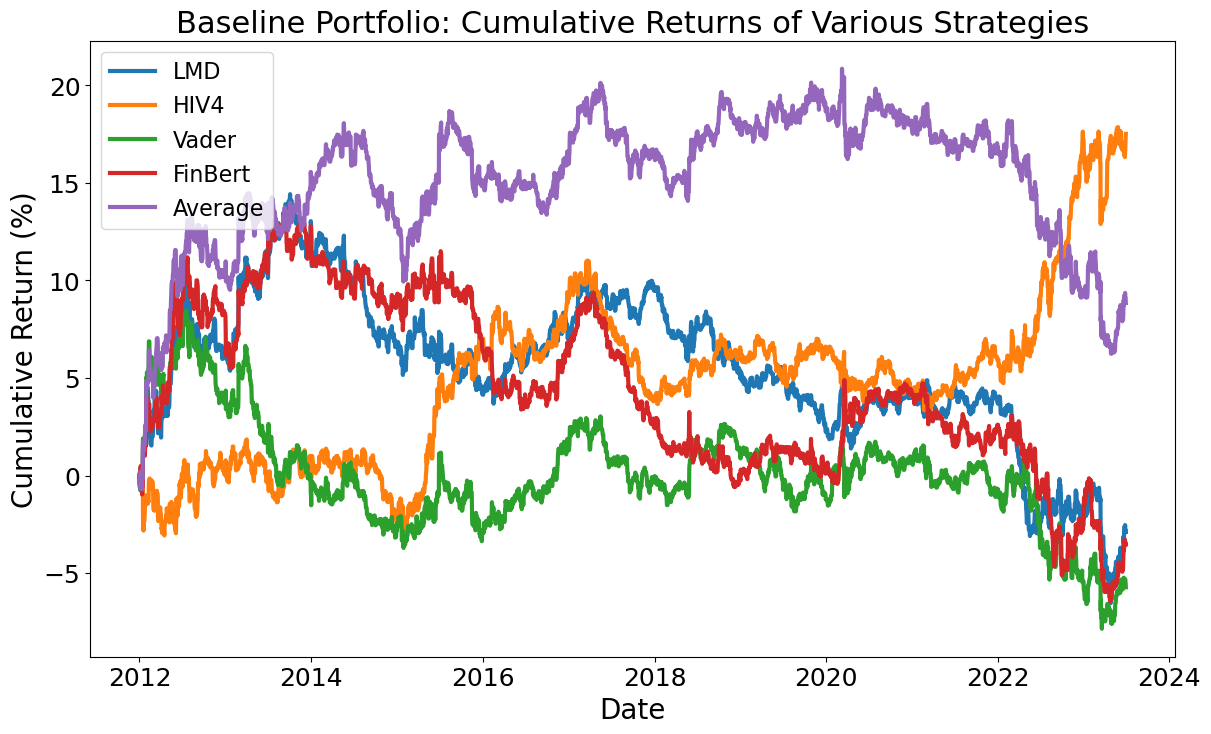

In [21]:
for strategy in strategies:
    df[f'{strategy}_cumulative'] = ((1 + df[strategy]/100).cumprod() - 1) * 100

# 绘图
plt.figure(figsize=(14, 8))
for strategy in strategies:
    plt.plot(df['Date'], df[f'{strategy}_cumulative'], label=f'{strategy}', linewidth=3)

plt.title('Baseline Portfolio: Cumulative Returns of Various Strategies', fontsize=22)
plt.xlabel('Date', fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.ylabel('Cumulative Return (%)', fontsize=20)
plt.yticks(fontsize=18, rotation=0)
plt.legend(fontsize=16)
# plt.tight_layout()
plt.savefig('../Data/Images/fig6-2.png', dpi=600)
plt.show()

In [17]:
# 输出每种策略的最大累积收益率
for strategy in strategies:
    max_cumulative_return = df[f'{strategy}_cumulative'].max()
    print(f"The maximum cumulative return for {strategy} is {max_cumulative_return:.2f}%")


The maximum cumulative return for LMD is 14.42%
The maximum cumulative return for HIV4 is 17.86%
The maximum cumulative return for Vader is 8.45%
The maximum cumulative return for FinBert is 13.00%
The maximum cumulative return for Average is 20.85%


In [18]:
import numpy as np
# 定义无风险利率，例如0.01代表1%
risk_free_rate = 0

# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

# 计算每种策略的夏普比率
for strategy in strategies:
    # 计算年化收益率，注意将日收益率转化为年化收益率
    annualized_return = ((1 + df[strategy]/100).mean()) ** 252 - 1

    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = df[strategy].std() * np.sqrt(252)

    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

# 输出结果
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"The Sharpe Ratio for {strategy} is {sharpe_ratio:.4f}")
 

The Sharpe Ratio for LMD is -0.0004
The Sharpe Ratio for HIV4 is 0.0033
The Sharpe Ratio for Vader is -0.0009
The Sharpe Ratio for FinBert is -0.0005
The Sharpe Ratio for Average is 0.0017


In [19]:
ir_dict = {}  # 用于存储 IR 的字典

for strategy in strategies:
    mean_return = np.mean(df[strategy])  # 计算平均收益
    std_dev = np.std(df[strategy])  # 计算标准差

    if std_dev != 0:
        information_ratio = mean_return / std_dev  # 计算 IR
    else:
        information_ratio = np.nan  # 如果标准差为0，则IR为未定义

    ir_dict[strategy] = information_ratio  # 存储到字典

print("Information Ratios:", ir_dict)

Information Ratios: {'LMD': -0.0026684922760924264, 'HIV4': 0.020961730469795475, 'Vader': -0.005949795801490337, 'FinBert': -0.0032723328229201016, 'Average': 0.010967028273985248}


In [20]:
# 定义无风险利率，例如0.01代表1%
risk_free_rate = 0

# 创建一个字典来保存每种策略的夏普比率
sharpe_ratios = {}

# 按照工作日计算，一年有大约252个交易日
annual_factor = np.sqrt(252)

# 计算每种策略的夏普比率
for strategy in strategies:
    # 计算年化收益率，注意将日收益率转化为年化收益率
    annualized_return = ((1 + df[strategy]).mean()) ** 252 - 1

    # 计算年化标准差，同样注意将日标准差转化为年化标准差
    annualized_std_dev = (df[strategy]).std() * annual_factor

    # 计算夏普比率
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_std_dev

    # 将计算结果存入字典
    sharpe_ratios[strategy] = sharpe_ratio

# 输出结果
for strategy, sharpe_ratio in sharpe_ratios.items():
    print(f"The Sharpe Ratio for {strategy} is {sharpe_ratio:.4f}")

The Sharpe Ratio for LMD is -0.0397
The Sharpe Ratio for HIV4 is 0.5749
The Sharpe Ratio for Vader is -0.0815
The Sharpe Ratio for FinBert is -0.0479
The Sharpe Ratio for Average is 0.2331
